In [1]:
import numpy as np
import awkward as ak
from coffea.nanoaod import NanoEvents
from uproot_methods import TLorentzVectorArray
import time
from uproot_methods import TVector2Array

## WZG NanoAOD analysis using Coffea (JIwoong)  
### 1. Read Files

In [2]:
!ls data/NanoAOD_files/scheme4_nano.root
fname = "data/NanoAOD_files/scheme4_nano.root"

data/NanoAOD_files/scheme4_nano.root


In [3]:
events = NanoEvents.from_file(fname)

### 2. Trigger & MET filter 
 - Trigger will be applied after the dataset is fixed
 - 2018 METFilters are applied

In [4]:
## Triggers & MET filter

met_filter_flags = {
     
        '2016': ['goodVertices',
                 'globalSuperTightHalo2016Filter',
                 'HBHENoiseFilter',
                 'HBHENoiseIsoFilter',
                 'EcalDeadCellTriggerPrimitiveFilter',
                 'BadPFMuonFilter'
             ],

        '2017': ['goodVertices',
                 'globalSuperTightHalo2016Filter',
                 'HBHENoiseFilter',
                 'HBHENoiseIsoFilter',
                 'EcalDeadCellTriggerPrimitiveFilter',
                 'BadPFMuonFilter',
                 'ecalBadCalibFilterV2'
             ],

        '2018': ['goodVertices',
                 'globalSuperTightHalo2016Filter',
                 'HBHENoiseFilter',
                 'HBHENoiseIsoFilter',
                 'EcalDeadCellTriggerPrimitiveFilter',
                 'BadPFMuonFilter',
                 'ecalBadCalibFilterV2'
             ]
    }


doubleelectron_triggers  ={
    '2018': [
    #        "HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ",
    #        "HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL",
            "HLT_DiEle27_WPTightCaloOnly_L1DoubleEG",
    #        "HLT_DoubleEle33_CaloIdL_MW",
    #        "HLT_DoubleEle25_CaloIdL_MW"
    #        "HLT_DoubleEle27_CaloIdL_MW",
    #        "HLT_DoublePhoton70"
            ]
        }



singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
            '2016': [
                'Ele27_WPTight_Gsf',
                'Ele105_CaloIdVT_GsfTrkIdT'
            ],
            '2017': [
                'Ele35_WPTight_Gsf',
                'Ele115_CaloIdVT_GsfTrkIdT',
                'Photon200'
            ],
            '2018': [
                'Ele32_WPTight_Gsf',   # Isolated
                #'Ele115_CaloIdVT_GsfTrkIdT',  # Non-Isolated
                #'Photon200' # high PT
            ]
        }

In [5]:
## met filter
year='2018'
is_met_filter=True
if not is_met_filter:
    met_filters =  np.ones(events.size, dtype=np.bool)
else:
    met_filters =  np.ones(events.size, dtype=np.bool)
    for flag in met_filter_flags[year]:
        if flag not in events.Flag.columns: continue # There is no ecalBadCalibFilterV2 in NanoAOD
        met_filters = met_filters & events.Flag[flag]
print(met_filters,met_filters.shape)

[ True  True  True ...  True  True  True] (17150,)


In [6]:
## double lepton trigger

is_ele_trigger=False
if not is_ele_trigger:
    ele_triggers_arr=np.ones(events.size, dtype=np.bool)
else:
    ele_triggers_arr = np.zeros(events.size, dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.columns: continue
        ele_triggers_arr = ele_triggers_arr | events.HLT[path]
print(ele_triggers_arr,ele_triggers_arr.shape)

[ True  True  True ...  True  True  True] (17150,)


In [7]:
events = events[met_filters & ele_triggers_arr]
print("Total {0} number of events are remain after triggger".format(events.shape[0]))

Total 17088 number of events are remain after triggger


 - Particle branch to array

In [8]:
Electron = events.Electron
Muon = events.Muon
Photon = events.Photon
MET = events.MET

#events.Electron['T'] = TVector2Array.from_polar(Electron.pt, Electron.phi) --> Ok
#events.MET['T'] = TVector2Array.from_polar(MET.pt, MET.phi) --> Raise Error

---
### 3. Particle Selection
 - MET > 20 GeV
 - PT$_{e,\gamma}$ > 20 GeV,  |$\eta_{l,\gamma}$| < 2.5,
 - Electron cutbased_id > 1 ( Loose )
 - Photon cutbased_id > 0 ( Loose )

---
#### How to apply cut in array-based method: Mask  
arr1 = [1,1,2,1]  
arr1_cut_mask = arr1 > 1  
> [ False, False, True, False ]  
  
Sel_arr1 = arr1[arr1_cut_mask]  
> [ 2 ]  

In [9]:
def Particle_Selection(MET,Electron,Photon):
    MET_mask = MET.pt > 20
    Electron_mask = (Electron.pt >20) & (np.abs(Electron.eta) < 2.5) & (Electron.cutBased > 1) 
    #Photon_mask = (Photon.pt > 20 ) & (np.abs(Photon.eta) < 2.5)  & (Photon.genPartFlav == 1) & (Photon.cutBasedBitmap > 0)
    
    Photon_mask = (Photon.pt > 20 ) & (np.abs(Photon.eta) < 2.5)  & (Photon.cutBasedBitmap > 0)
    return(MET_mask,Electron_mask,Photon_mask)

In [10]:
MET_mask,Electron_mask,Photon_mask = Particle_Selection(MET,Electron,Photon)

In [11]:
Ele_Sel_mask = Electron[Electron_mask].counts > 2
Pho_Sel_mask = Photon[Photon_mask].counts > 0

Event_mask = Ele_Sel_mask & Pho_Sel_mask 

In [12]:
print(" - Electron Cut Eff: {0} %".format(
    np.sum(Electron_mask.content) /  len(Electron_mask.content) * 100
    ))

print(" - Photon Cut Eff: {0} %".format(
    np.sum(Photon_mask.content) /  len(Photon_mask.content) * 100
    ))

print(" - Event Selection Eff: {0}%  | number of selected events: {1}".format(
    np.sum(Event_mask) /  len(Event_mask) * 100, np.sum(Event_mask)
    ))

 - Electron Cut Eff: 55.175001103411745 %
 - Photon Cut Eff: 62.587950470330114 %
 - Event Selection Eff: 2.1769662921348316%  | number of selected events: 372


---
### 4. Event Selection - eee channel

In [13]:
Ele_channel_events = events[Event_mask]

In [14]:
Ele = Ele_channel_events.Electron
Pho = Ele_channel_events.Photon
Met = Ele_channel_events.MET

In [15]:
print(Ele.shape)
print(Pho.shape)
print(Met.shape)

(372,)
(372,)
(372,)


### Choose OSSF

1. Choose possible triplets    
> Electron array:[[e1,e2,e3], [e4,e5,e6,e7]  ....]  
Choose(3)  
> [(e1,e2,e3), [(e4,e5,e6) (e4,e5,e7) (e5,e6,e7)]  ....]  

2. Veto same sign triplet and events
> [(), [(e4,e5,e6) (e4,e5,e7) (e5,e6,e7)]  ....]  
> [[(e4,e5,e6) (e4,e5,e7) (e5,e6,e7)]  ....]  

3. Select High-PT Triplet  
> [[(e4,e5,e6)] [(e8,e9,e10)]  ....]  
One triplet per one events  

veto same sign triplet efficiency ( per events ) : 94.62%




In [16]:
Tri_ele = Ele.choose(3)

## ---Veto same sign set and events
N_Before_ss_filter = Tri_ele.shape[0]
Tri_SSVeto_Mask =  ~(( Tri_ele.i0.charge == Tri_ele.i1.charge ) == Tri_ele.i2.charge )
Tri_ele = Tri_ele[Tri_SSVeto_Mask]

Tri_SSVeto_evtMask = Tri_ele.counts > 0
Tri_ele = Tri_ele[Tri_SSVeto_evtMask]
MET_SSVeto = Met[Tri_SSVeto_evtMask]

N_After_ss_filter = Tri_ele.shape[0]

print("Veto SS Eff: {0}%".format(round(N_After_ss_filter / N_Before_ss_filter * 100,2 )))

## ---Select High-PT ordered set
Tri_ele = Tri_ele[Tri_ele.i0.pt.argmax()]## Select 1 set of 3 leptons

Veto SS Eff: 94.62%


### Choose OSSF lepton pairs that meet Zmass window 
1. Select pair to caclulate invariant mass  
[[(e4,e5,e6)] [(e8,e9,e10)] ....]
 - i0 = [(e4,e8)....]  
 - i1 = [(e5,e9)....]  
 - i2 = [(e6,e10)....]  
 - e1e2 = i0i1  
 - e1e3 = i0i2
 - e2e3 = i1i2  
 
2. OSSF zmass check (veto offshell)
 - Opposite charge 
 - |M(Z) - M(p1p2)] < 30 GeV  
 
3. Exclude events that cannot meet the criteria of OSSF_zmass_check  
 - e1e2 Eff:  39%
 - e1e3 Eff:  55%
 - e2e3 Eff:  40%

In [17]:
#Tri_ele_list  = [list(x[0]) for x in Tri_ele]
def ossf_zmass_check(p1,p2):
    return ((p1.charge != p2.charge) & 
            (np.abs(91.18 - (p1 + p2).mass) < 30.))

e1e2 = ossf_zmass_check(Tri_ele.i0,Tri_ele.i1)
e1e3 = ossf_zmass_check(Tri_ele.i0,Tri_ele.i2)
e2e3 = ossf_zmass_check(Tri_ele.i1,Tri_ele.i2)

print("e1e2 Eff: ",Tri_ele[Tri_ele[e1e2].counts >0].shape[0] / Tri_ele.shape[0] * 100 )
print("e1e3 Eff: ",Tri_ele[Tri_ele[e1e3].counts >0].shape[0] / Tri_ele.shape[0] * 100 )
print("e2e3 Eff: ",Tri_ele[Tri_ele[e2e3].counts >0].shape[0] / Tri_ele.shape[0] * 100 )

e1e2 Eff:  38.92045454545455
e1e3 Eff:  54.54545454545454
e2e3 Eff:  40.340909090909086


#### Calculate Z mas and  W MT

In [18]:
Triplet = Tri_ele[Tri_ele[e1e3].counts >0]
MET_OSSF = MET_SSVeto[Tri_ele[e1e3].counts>0]

In [19]:
## -- Z mass 
Di_ele = Triplet.i0 + Triplet.i2
Mee = Di_ele.mass.content
Mee.shape

(192,)

In [20]:
## -- W MT

# 1) Events that pass ossf_zmaas_check
MET_T = TVector2Array.from_polar(MET_OSSF.pt, MET_OSSF.phi)
ELE_T = TVector2Array.from_polar(Triplet.i1.pt, Triplet.i1.phi)
mT =  np.sqrt( 2*Triplet.i1.pt.sum() * MET_OSSF.pt * ( 1 - np.cos(MET_T.delta_phi(ELE_T.sum()))))
mT.shape

# 2) Events that pass the same sign check 
#MET_T = TVector2Array.from_polar(MET_SSVeto.pt, MET_SSVeto.phi)
#ELE_T = TVector2Array.from_polar(Tri_ele.i1.pt, Tri_ele.i1.phi)
#mT_loose =  np.sqrt( 2*Tri_ele.i1.pt.sum() * MET_SSVeto.pt * ( 1 - np.cos(MET_T.delta_phi(ELE_T.sum()))))

(192,)

### Visualization

In [21]:
import mplhep as hep
import matplotlib.pyplot as plt

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


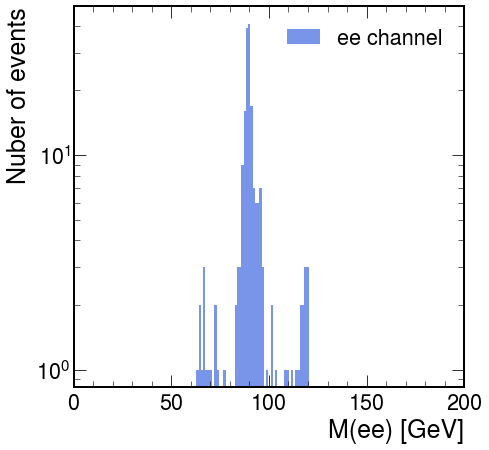

In [22]:
plt.figure(figsize=(7, 7))
plt.style.use(hep.style.CMS)
plt.hist(Mee,bins=50,color='royalblue',alpha=0.7,label='ee channel')
plt.xlim(0,200)
plt.xlabel('M(ee) [GeV]',fontsize=25)
plt.ylabel('Nuber of events',fontsize=25)
plt.yscale('log')
plt.legend()

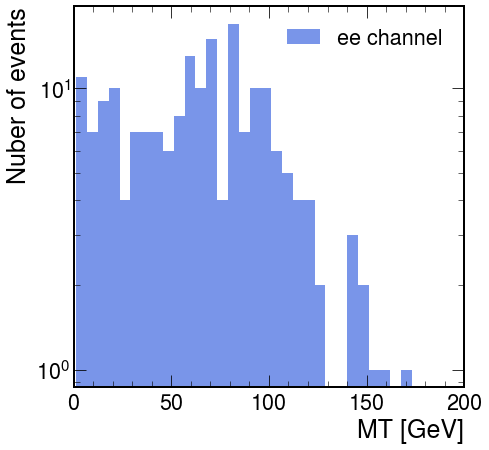

In [24]:
plt.close()
plt.figure(figsize=(7, 7))
plt.hist(mT,bins=50,color='royalblue',alpha=0.7,label='ee channel')
plt.xlim(0,200)
plt.xlabel('MT [GeV]',fontsize=25)
plt.ylabel('Nuber of events',fontsize=25)
plt.yscale('log')
plt.legend()

In [ ]:
## --- Not now ...
#def delta_r(pair):
#    return pair.i0.delta_r(pair.i1)

#JselE_pair = Jet.cross(Sel_Electron,nested=True)
#dr_JselE_mask = (delta_r(JselE_pair) > 0.3).any()

#JselA_pair = Jet.cross(Sel_Photon,nested=True)
#dr_JselA_mask = (delta_r(JselA_pair)>0.3).any()


#Jet_mask = Jet_basic_mask & dr_JselE_mask & dr_JselA_mask